## 1. Overview 
1. We want to evaluate a certain portfolio, and how the portfolio compares to other allocation. 
2. First we obtain a prediction of each holding's expected return by decomposing its returns to different factors (75 different factor portfolio constructed by the fama french library)
3. Using this prediction of expected return, we then compares this portfolio weighting to other traditional portfolio weights, and backtest them. 
4. Using weights and predicted expected returns, we predict the portfolio returns using the MSR weights, and compare to the posted returns by the company. 

In [54]:
import pandas as pd 
import numpy as np 
import yfinance as yf 
import matplotlib 
import matplotlib.pyplot as plt 
import pandas_datareader.data as web

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from scipy.optimize import minimize
import datetime 

import utils as ut
import advstatmodel as adv 
import warnings

warnings.filterwarnings('ignore')

In [55]:
## params 

HOLDINGS = ['AVGO', 'MSFT', 'AAPL', 'TSM', 'AMZN', 'GOOGL', 'META', 'ASML', 'ORCL' ] ## MODIFY ACCORDING TO THE PORTFOLIO HOLDINGS THAT YOU WANT TO ANALYSE 
START = "2018-01-01"
END = "2025-12-01"
WINDOW = 60 


In [56]:
## download ff portfolio data using web reader - else we could download the CSV 

def get_data(): 
    price = yf.download(HOLDINGS, start = START, end = END)['Close']
    returns = price.resample('M').last().pct_change().dropna() 
    returns.index = returns.index.to_period('M')

    print("--- Fetching 75 porfolios ---")
    try: 
        f1 = web.DataReader('25_Portfolios_5x5', 'famafrench', start = START, end = END)[0]
        f2 = web.DataReader('25_Portfolios_Op_Inv', 'famafrench', start = START, end = END)[0]
        f3 = web.DataReader('25_Portfolios_ME_Prior_12_2', 'famafrench', start = START, end = END)[0]
        factors = pd.concat([f1, f2, f3], axis=1) / 100.0

    except Exception as e:
        print(f"API Warning: {e}. Using Synthetic Factors.")
        factors = pd.DataFrame(np.random.normal(0, 0.03, (len(returns), 75)), index=returns.index)

    # risk free rate 
    try: 
        rf = web.DataReader("F-F_Research_Data_Factors", 'famafrench', start = START, end = END)[0]['RF'] / 100.0

    except Exception as e: 
        print(f'Warning {e}. Setting default rf')
        rf = pd.Series(0.03, index = returns.index)
        rf.index = rf.index.strftime

    # check if returns and factors have the same lenth 
    if len(returns.index) != len(factors.index): 
        print(f'Warning. Returns length: {len(returns.index)} vs Factors length: {len(factors.index)}' )

    common = returns.index.intersection(factors.index).intersection(rf.index)
    return returns.loc[common], factors.loc[common], rf.loc[common]



## 2. Machine Learning 
1. We employ LASSO and RIDGE regression to prevent overfitting. Also, since the portfolios are highly collinear, we need to use LASSO and RIDGE to "learn" the portfolio loadings. 

In [57]:
def get_forecasts(returns, factors, t, window, model_type='lasso'):
    train_ret = returns.iloc[t-window:t]
    train_fac = factors.iloc[t-window:t]
    
    # Lagged Features (t-1) -> Target (t)
    X = train_fac.shift(1).dropna()
    y = train_ret.loc[X.index]
    X_curr = train_fac.iloc[[-1]]
    
    forecasts = []
    
    # DEFINE MODELS
    if model_type == 'lasso':
        # Selection: Pick specific factors
        model = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))
    elif model_type == 'pcr':
        # Extraction: Reduce 75 factors to 5 latent drivers, then regress
        model = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())
    elif model_type == 'ridge': 
        model = make_pipeline(StandardScaler(), RidgeCV(cv = 5))
    
    for ticker in returns.columns:
        model.fit(X, y[ticker])
        pred = model.predict(X_curr)[0]
        forecasts.append(pred)
        
    return np.array(forecasts), train_ret.cov().values

# ==========================================
# 4. OPTIMIZER
# ==========================================
def optimize_weights(mu, cov):
    n = len(mu)
    if mu.max() < 0: return np.array([1/n]*n) # Defensive
    
    def neg_sharpe(w):
        r = w @ mu
        v = np.sqrt(w.T @ cov @ w)
        return -(r / v) if v > 0 else 0
    
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0, 1.0) for _ in range(n))
    res = minimize(neg_sharpe, [1/n]*n, bounds=bounds, constraints=cons)
    return res.x

In [ ]:
def main(): 
    returns, factors, rf = get_data()
    dates = returns.index
    
    # Curves
    curve_fund = [100.0]
    curve_lasso = [100.0]
    curve_pcr = [100.0]
    curve_ridge =[100.0]
    
    print(f"\n--- Running Audit: Lasso vs PCR vs Fund ---")
    
    for t in range(WINDOW, len(dates)):

        tscv = TimeSeriesSplit(n_splits=5)  # walk-forward CV

        alphas_lasso = np.logspace(-4, 0, 60)   # tune as needed
        alphas_ridge = np.logspace(-3, 3, 80)
        
        # 1. The Fund (Static Equal Weight)
        ret_fund = returns.iloc[t].mean()
        curve_fund.append(curve_fund[-1] * (1 + ret_fund))
        
        # 2. Lasso Audit (Selection)
        mu_l, cov_l = get_forecasts(returns, factors, t, WINDOW, 'lasso')
        w_l = optimize_weights(mu_l, cov_l)
        ret_l = np.dot(w_l, returns.iloc[t].values)
        curve_lasso.append(curve_lasso[-1] * (1 + ret_l))
        
        # 3. PCR Audit (Extraction)
        mu_p, cov_p = get_forecasts(returns, factors, t, WINDOW, 'pcr')
        w_p = optimize_weights(mu_p, cov_p)
        ret_p = np.dot(w_p, returns.iloc[t].values)
        curve_pcr.append(curve_pcr[-1] * (1 + ret_p))

        # 4. ridge 
        mu_r, cov_r = get_forecasts(returns, factors, t, WINDOW, 'ridge') 
        w_r = optimize_weights(mu_r, cov_r)
        ret_r = np.dot(w_r, returns.iloc[t].values) 
        curve_ridge.append(curve_ridge[-1] * (1 + ret_r))
        
        if t % 12 == 0:
            print(f"{dates[t]} | Fund: {curve_fund[-1]:.0f} | Lasso: {curve_lasso[-1]:.0f} | PCR: {curve_pcr[-1]:.0f} | Ridge: {curve_ridge[-1]:.0f}")

    # Results
    res = pd.DataFrame({
        'Fund Proxy': curve_fund,
        'Lasso (Select)': curve_lasso,
        'PCR (Extract)': curve_pcr, 
        'Ridge': curve_ridge
    }, index=[dates[WINDOW-1]] + list(dates[WINDOW:]))
    
    print("\n--- FINAL RETURNS ---")
    print(res.iloc[-1] / res.iloc[0] - 1)
    
    res.plot(title="Audit Result: Selection (Lasso) vs Extraction (PCR)", figsize=(10,6))
    plt.grid(True); plt.show()

[*********************100%***********************]  9 of 9 completed


--- Fetching 75 porfolios ---
API Warning: Unable to read URL: http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/25_Portfolios_Op_Inv_CSV.zip
Response Text:
b'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\r\n<html xmlns="http://www.w3.org/1999/xhtml">\r\n<head>\r\n<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1"/>\r\n<title>404 - File or directory not found.</title>\r\n<style type="text/css">\r\n<!--\r\nbody{margin:0;font-size:.7em;font-family:Verdana, Arial, Helvetica, sans-serif;background:#EEEEEE;}\r\nfieldset{padding:0 15px 10px 15px;} \r\nh1{font-size:2.4em;margin:0;color:#FFF;}\r\nh2{font-size:1.7em;margin:0;color:#CC0000;} \r\nh3{font-size:1.2em;margin:10px 0 0 0;color:#000000;} \r\n#header{width:96%;margin:0 0 0 0;padding:6px 2% 6px 2%;font-family:"trebuchet MS", Verdana, sans-serif;color:#FFF;\r\nbackground-color:#555555;}\r\n#content{margin:0 0 0 2%;position:relative;}\r\n.content-

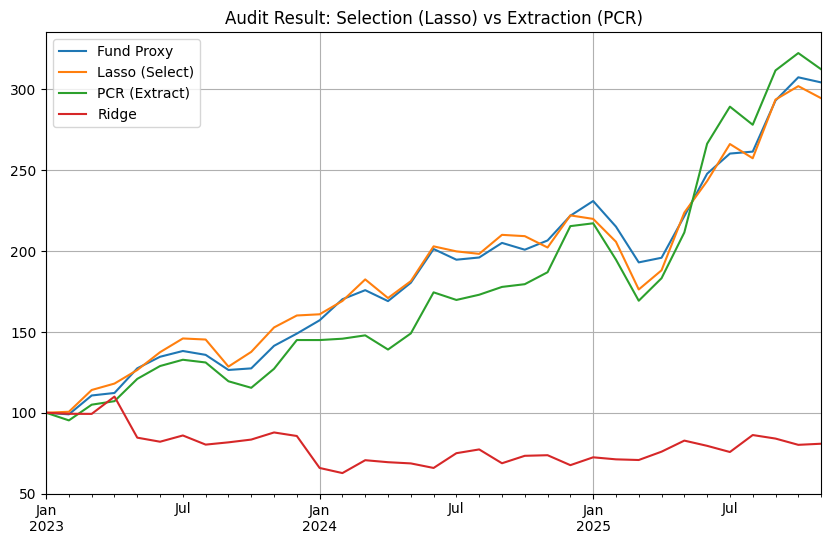

In [68]:
main()